In [1]:
import os
import progressbar
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import biograph.graph_models as graph_models

os.chdir("../")

### Graph verification and preprocessing

In [2]:
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("graphs/") if ".pkl" in fn]
#filenames = ["3KEU.pkl"]
graphs = [load_graph("graphs/"+fn) for fn in filenames]
print("Loaded {} graphs".format(len(graphs)))

Loaded 1228 graphs


In [3]:
def remove_interior(graph):
    edges_to_remove = set()
    nodes_to_remove = set()
    for node_idx, adj_dict in graph.adjacency():
        neighbors_not_in_surf = [k for k,v in adj_dict.items() if not v["in_surf"]]
        edges_to_remove.update([
            (node_idx, neighbor)  if node_idx < neighbor else (neighbor, node_idx) 
            for neighbor in neighbors_not_in_surf])
        if len(adj_dict) == len(neighbors_not_in_surf):
            nodes_to_remove.add(node_idx)
    edges_before = graph.number_of_edges()
    nodes_before = graph.number_of_nodes()
    for edge in edges_to_remove:
        graph.remove_edge(*edge)
    for idx in nodes_to_remove:
        graph.remove_node(idx)
    return graph
#edges_before, graph.number_of_edges(), nodes_before, graph.number_of_nodes()

In [4]:
graphs = [remove_interior(graph) for graph in graphs]

In [5]:
for i in progressbar.progressbar(range(len(graphs))):
    graphs[i] = graph_models.GraphModel.get_diffused_graph(graphs[i], steps=3)

100% (1228 of 1228) |####################| Elapsed Time: 0:05:53 Time:  0:05:53


In [6]:
import biograph.constants
def touches_ligand(x):
    return x <= 4 or (x<=6 and np.random.binomial(1, 1-(x-4)/2) == 1)
dataframes = {} # chain_id to dataframe
for graph in progressbar.progressbar(graphs):
    df = graph_models.GraphModel.graph_to_dataframe(graph)
    # One hot for AAs
    for code3 in biograph.constants.AMINOACIDS_3 + ["UNK"]:
        df[code3] = (df.resname == code3).astype(np.int)
    
    for i, coord in enumerate(["x", "y", "z"]):
        df[coord] = df.coord.map(lambda x: x[i])
        
    df["target"] = df.distance.map(touches_ligand).astype(np.int)
    df = df[[c for c in df.columns if "distance_" not in c]]
    df = df.drop(["full_id","resname", "coord", "distance"], axis=1)
    for chain in df.chain.unique():
        dataframes[chain] = df.loc[df.chain==chain].drop(["chain"], axis=1)

100% (1228 of 1228) |####################| Elapsed Time: 0:01:04 Time:  0:01:04


In [7]:
print([df.columns for df in list(dataframes.values())[0:1]])

[Index(['depth_1', 'depth_2', 'depth_3', 'bfactor_1', 'bfactor_2', 'bfactor_3',
       'depth', 'bfactor', 'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR',
       'TRP', 'TYR', 'VAL', 'UNK', 'x', 'y', 'z', 'target'],
      dtype='object')]


In [ ]:
# todo: class balance

## Example model

### Data splits and preprocessing

In [8]:
with open("names_groups.pkl", "rb")  as f:
    names, groups = pickle.load(f)

In [9]:
# sanity check: each protein's chains belong only to one cluster..?
counter = 0
for pdbid, chains in names.items():
    clusters = [groups[chain] for chain in chains if groups[chain] is not None]
    if len(set(clusters)) > 1:
        counter += 1
        print("There is a protein, {}, with different clusters different chains".format(pdbid))
        print("Groups not ignoring None:",
             [groups[chain] for chain in chains])
        continue
    

There is a protein, 2RD5, with different clusters different chains
Groups not ignoring None: [496, 496, 876, 876]
There is a protein, 5ECP, with different clusters different chains
Groups not ignoring None: [129, 720, 720, 129, 720, 720]
There is a protein, 6REP, with different clusters different chains
Groups not ignoring None: [973, 105, 271, 483, 556, 903, 834, 776, 963, 950, 896, 896, 896, 896, 896, 896, 896, 896, 896, 896, 480, 712, 989, 759, 498, 137, 137, 137, 130, 130, 130]
There is a protein, 2YCH, with different clusters different chains
Groups not ignoring None: [376, 1034]
There is a protein, 4WB5, with different clusters different chains
Groups not ignoring None: [325, 1030]
There is a protein, 6GJS, with different clusters different chains
Groups not ignoring None: [12, 837, 855]
There is a protein, 4EAK, with different clusters different chains
Groups not ignoring None: [939, 965, 471]
There is a protein, 2A40, with different clusters different chains
Groups not ignoring

In [10]:
groups.get("3RRF_A") is not None

True

In [11]:
# Concatenate dataframes and assign groups
for chain in dataframes.keys():
    # usage of .get is intentional (fails on 5A99 that has "no sequences")
    dataframes[chain]["group"] = groups.get(chain) if groups.get(chain) is not None else np.nan

dataset = pd.concat(dataframes, ignore_index=True)
dataset = dataset.loc[dataset.group.notna()]
row_groups = dataset.group
row_target = dataset.target

dataset = dataset.drop(["target", "group"], axis=1)
dataset.head()

,depth_1,depth_2,depth_3,bfactor_1,bfactor_2,bfactor_3,depth,bfactor,ALA,ARG,...,PRO,SER,THR,TRP,TYR,VAL,UNK,x,y,z
0,4.879296,7.683482,9.008506,31.776667,34.335385,36.118400,0.000000,31.48,0,0,...,0,0,0,0,0,0,0,-0.238000,25.985001,108.763000
1,4.303906,5.960399,8.143470,36.288000,37.284545,37.212632,7.372662,29.98,0,0,...,0,0,0,0,0,0,0,5.892000,35.036999,109.164001
2,14.684737,14.891444,15.608048,34.141667,35.970000,33.513158,13.230346,29.43,0,0,...,0,0,0,0,0,0,0,27.721001,38.990002,104.329002
3,5.901673,3.102928,4.607086,41.570000,42.742000,34.572917,0.000000,43.58,0,0,...,0,1,0,0,0,0,0,15.172000,37.265999,124.517998
4,1.968182,5.364153,6.347030,52.600000,41.383636,33.349500,3.886651,54.74,0,0,...,0,0,0,0,0,0,0,14.853000,41.509998,122.211998


In [12]:
# class %
row_target.sum()/row_target.shape[0]*100

2.220192211432576

In [13]:
import sklearn.model_selection
import sklearn.metrics
import xgboost as xgb

param = {
    'eta': 0.3268179417171394,
    'max_depth': 8,
    'min_child_weight': 0.5460906834882965,
    'objective': "binary:logistic",
    'nthread': 4
}
groupk= sklearn.model_selection.GroupKFold(n_splits=5)
clf = xgb.XGBClassifier(**param)
res = sklearn.model_selection.cross_validate(
    clf, dataset, y=row_target, groups=row_groups,
    cv=groupk, n_jobs=3, scoring="roc_auc", verbose=1, return_estimator=True)
res

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.7min finished


{'fit_time': array([57.99667811, 58.50080109, 58.41473007, 43.41267467, 43.93616557]),
 'score_time': array([0.23446178, 0.21413708, 0.25698423, 0.20438361, 0.19454932]),
 'estimator': (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, eta=0.3268179417171394,
                gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
                min_child_weight=0.5460906834882965, missing=nan,
                n_estimators=100, n_jobs=1, nthread=4,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=1, verbosity=1),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, eta=0.3268179417171394,
                gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
                min_child_weight=0.5460906834882965,

In [ ]:
 'test_score': array([0.82886439, 0.76342523, 0.7909759 , 0.77444309, 0.78819711])}


In [28]:
preds = res["estimator"][0].predict(dataset)

In [37]:
pred_class[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
for estimator in res["estimator"]:
    preds = estimator.predict(dataset)
    print("Precision: ", sklearn.metrics.precision_score(row_target, preds))
    print("Recall: ", sklearn.metrics.recall_score(row_target, preds))
    pred_class = np.copy(preds)
    pred_class[pred_class > 0.5] = 1
    pred_class[pred_class <= 0.5] = 0
    print("AUC: ", sklearn.metrics.roc_auc_score(row_target, pred_class))
    print("Confusion matrix: \n", sklearn.metrics.confusion_matrix(row_target, preds))

Precision:  0.8150428265524625
Recall:  0.11732747659230147
AUC:  0.5583238745957582
Confusion matrix: 
 [[1015893     691]
 [  22908    3045]]
Precision:  0.8320732192598488
Recall:  0.08056872037914692
AUC:  0.540076802329131
Confusion matrix: 
 [[1016162     422]
 [  23862    2091]]
Precision:  0.9115841178878428
Recall:  0.0858089623550264
AUC:  0.542798243030936
Confusion matrix: 
 [[1016368     216]
 [  23726    2227]]
Precision:  0.8368638239339753
Recall:  0.11721188301930413
AUC:  0.558314278449836
Confusion matrix: 
 [[1015991     593]
 [  22911    3042]]
Precision:  0.8419864559819413
Recall:  0.11497707394135552
AUC:  0.557213104738811
Confusion matrix: 
 [[1016024     560]
 [  22969    2984]]


array([[1015893,     691],
       [  22908,    3045]])

0.11732747659230147

0.5583238745957582

In [14]:
from scipy.stats import uniform
import time


groupk= sklearn.model_selection.GroupKFold(n_splits=5)
clf = xgb.XGBClassifier(**param)

#sklearn.model_selection.cross_validate(
#    clf, dataset, y=row_target, groups=row_groups,
#    cv=groupk, n_jobs=1, scoring="roc_auc", verbose=1)

clf = sklearn.model_selection.RandomizedSearchCV(
    clf, {"max_depth": list(range(3,10)), 
          "min_child_weight": uniform(loc=0.5, scale=1.5), # ~U(loc, loc+scale)
          "eta": uniform(loc=0.2, scale=0.3)},
    cv=groupk, n_iter=50, scoring="roc_auc", verbose=5, n_jobs=3)

start = time.time()
search = clf.fit(dataset, row_target, row_groups)
end = time.time()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 13.4min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 27.5min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 44.1min finished


In [15]:
search.cv_results_

{'mean_fit_time': array([22.19056463, 47.6857697 , 34.2346724 , 55.01021867, 27.98742404,
        21.98512888, 47.52398715, 27.91141348, 54.16122746, 47.98624802,
        22.30929008, 22.28337307, 16.83297653, 54.50769324, 22.41503654,
        16.88460026, 28.21364412, 16.88295679, 16.76804757, 22.13472748,
        47.53991456, 16.85944476, 22.27360768, 16.71738648, 54.25686431,
        47.7333859 , 17.10201898, 22.08151278, 16.79709592, 40.69106946,
        47.43109307, 16.68614817, 54.77079635, 40.56631269, 34.1283762 ,
        28.02987199, 22.03069749, 47.81180043, 16.77182932, 34.0654099 ,
        16.81593866, 28.01798501, 16.85237927, 27.80587287, 41.00269923,
        16.84718041, 34.20564332, 47.58120875, 40.79467273, 33.47456875]),
 'std_fit_time': array([0.02038893, 0.38484124, 0.53782996, 0.42418305, 0.43893945,
        0.14068392, 0.19174123, 0.16428591, 0.26412309, 0.58795841,
        0.26432563, 0.37582757, 0.14322595, 0.45453303, 0.16637995,
        0.07377963, 0.55345556,

In [16]:
search.best_params_, search.best_score_

({'eta': 0.2908943047499787,
  'max_depth': 4,
  'min_child_weight': 1.4515751868964448},
 0.8092938725829367)

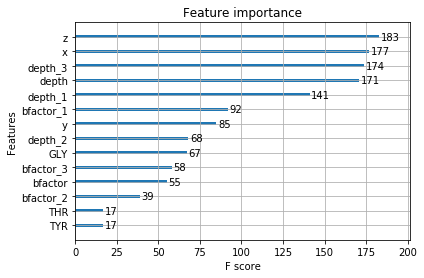

In [17]:

xgb.plot_importance(search.best_estimator_, max_num_features=14)